In [137]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
from tqdm import tqdm
import scipy.ndimage as nd
from torchvision import transforms
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = 15, 10

In [2]:
import os
!wget https://images.wallpapersden.com/image/download/cloudy-mountains_66340_3840x2160.jpg

--2020-08-30 03:34:47--  https://images.wallpapersden.com/image/download/cloudy-mountains_66340_3840x2160.jpg
Resolving images.wallpapersden.com (images.wallpapersden.com)... 172.67.205.249, 104.27.190.80, 104.27.191.80, ...
Connecting to images.wallpapersden.com (images.wallpapersden.com)|172.67.205.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6836505 (6.5M) [image/jpeg]
Saving to: ‘cloudy-mountains_66340_3840x2160.jpg’

cloudy-mountains_66 100%[===================>]   6.52M  5.68MB/s    in 1.1s    

2020-08-30 03:34:50 (5.68 MB/s) - ‘cloudy-mountains_66340_3840x2160.jpg’ saved [6836505/6836505]



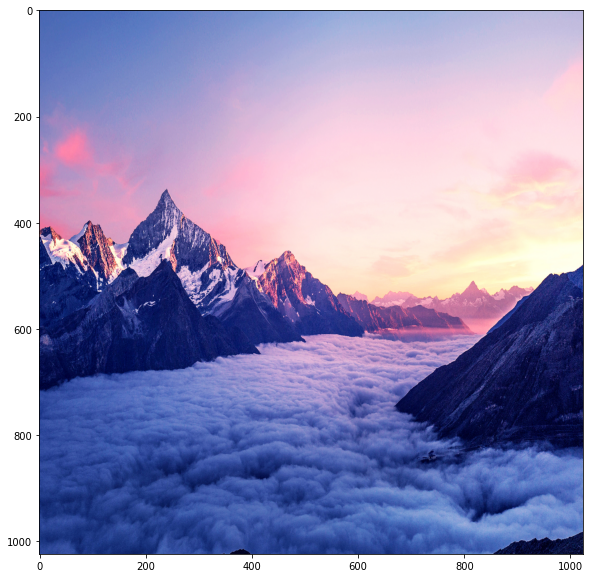

In [130]:
import cv2 

image_main = cv2.imread("cloudy-mountains_66340_3840x2160.jpg")
image_sample = cv2.cvtColor(image_main, cv2.COLOR_BGR2RGB)
image_sample = cv2.resize(image_sample, (1024,1024))


plt.rcParams['figure.figsize'] = 15, 10
plt.imshow(image_sample)
plt.show()



In [141]:
model = models.vgg19(pretrained=True)
layers = list(model.features.children())
model.eval()
if torch.cuda.is_available:
    model = model.cuda()
# print(model)

In [132]:

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()


def preprocess_func(image_np):

    """
    specific for VGG19
    """

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    return preprocess(image_np)

def deprocess_func(image_tensor):

    """
    specific for VGG19
    """

    denorm = transforms.Compose([ 
                                 transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
                                ])
    return denorm(image_tensor)

def find_random_roll_values_for_tensor(image_tensor):

    """
    image_tensor.size() should be (width, height, color_channels)
    """

    roll_x = image_tensor.size()[-1]
    roll_y = image_tensor.size()[-2]

    return roll_x, roll_y


def roll_torch_tensor(image_tensor, roll_x, roll_y):

    """
    rolls a torch tensor on both x and y axis 
    """

    rolled_tensor = torch.roll(torch.roll(image_tensor, shifts = roll_x, dims = -1), shifts = roll_y, dims = -2)

    return rolled_tensor

In [133]:
def deep_dream(image_np, model, layer_index, octave_scale, num_octaves, iterations, lr):
    original_size = image_np.shape[:2]
    layer = list( model.features.modules() )[layer_index]

    for n in range(-num_octaves, 1):
        octave_size = tuple( np.array(original_size) * octave_scale**n)
        new_size = (int(octave_size[1]), int(octave_size[0]))

        image_np = cv2.resize(image_np, new_size)

        image_np = dream(image_np, model, layer, iterations = iterations, lr = lr, out_channels = None)

    return image_np

In [138]:

#Function to make gradients calculations from the output channels of the target layer.
def get_gradients(net_in, net, layer, out_channels = None):     
    net_in = net_in.unsqueeze(0)
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)
    if out_channels == None:
        loss = hook.output[0].norm()
    else:
        loss = hook.output[0][out_channels].norm()
    loss.backward()
    return net_in.grad.data.squeeze()

#By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image_np, net, layer, iterations, lr, out_channels = None):

    image_tensor = preprocess_func(image_np).cuda()

    for i in tqdm(range(iterations)):

        roll_x, roll_y = find_random_roll_values_for_tensor(image_tensor)
      
        image_tensor_rolled = roll_torch_tensor(image_tensor, roll_x, roll_y) 

        gradients_tensor = get_gradients(image_tensor_rolled, net, layer, out_channels).detach()

        gradients_tensor = roll_torch_tensor(gradients_tensor, -roll_x, -roll_y)  ## on the GPU

        image_tensor.data = image_tensor.data + lr * gradients_tensor.data ## can confirm this is still on the GPU

    img_out = image_tensor.detach().cpu()

    img_out = deprocess_func(img_out)
    img_out_np = img_out.numpy()

    img_out_np = img_out_np.transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    
    return img_out_np


In [139]:
dreamed = deep_dream(
                     image_sample, 
                     model,
                     layer = 19, 
                     octave_scale = 1.5, 
                     num_octaves = 7, 
                     iterations = 35, 
                     lr = 0.09 
                     )

100%|██████████| 35/35 [00:09<00:00,  3.83it/s]


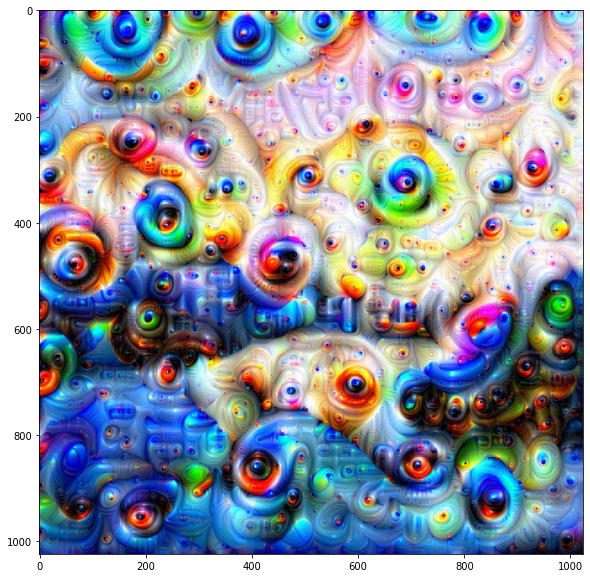

In [140]:
plt.imshow(dreamed)